In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def draw_contours(image, box):
    cv2.drawContours(image,[box],0,(100,0,255),2)
    
def get_rect_centroid(rect):      
    coords = ((rect[0][0] + rect[1][1])//2,(rect[0][1] + rect[1][0])//2)   
    return coords

def draw_line(img, line, color=[100, 0, 255], thickness=5):  
    x1, x2, y1, y2 = line
    #print x1, x2, y1, y2
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

def resize(image, newsize):
    return cv2.resize(image,(newsize[0], newsize[1]), interpolation = cv2.INTER_CUBIC)

def draw_image(source, image, x, y):
    height = image.shape[0]
    width  = image.shape[1]
    
    
    max_y = y + height
    #if max_y > source.shape[0]:
        #max_y -= max_y - source.shape[0] + 1
        
    #print x, y, width, height
    max_x = x + width
    alpha = image[:, :, 3] / 255.0
    
    #if max_x > source.shape[1]:
        #max_x -= max_x - source.shape[1] + 1
    #print source.shape, y, max_y, x, max_x
    #source [1:2, 1:2, 1]
    for c in range(0,3):
        color = image[:, :, c] * (alpha)
        beta  = source [y:max_y, x:max_x, c] * (1.0 - alpha)
        source[y:max_y, x:max_x, c] = color + beta
    return source

In [3]:
watch = cv2.imread('/home/taras/Downloads/watch.png', -1)
def draw_watch(image, x, y, width, height, angle):    
    resized = resize(watch, (width, height))
    
    rotated = rotate_bound(resized, angle - 90)
    draw_image(image, rotated, x, y)
    return image

In [4]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [5]:
def get_max_countour(thresholded):    
    image, countours, hierarchies = cv2.findContours(thresholded,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    count = len(countours)
    if count <= 0:
        return []
    
    max_area = 100    
    max_index = -1
    for i in range(count):
        countour = countours[i]
        area = cv2.contourArea(countour)
        if ( max_area < area):
            max_area = area
            max_index = i
            
    if max_index == -1:
        return []
                
    return countours[max_index]

def get_bounding_box(cont):
    rect = cv2.minAreaRect(cont)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return box, rect

In [123]:
def cropRotated(image, rect):
   
    center, size, angle = rect  
    
    if angle < -45.0  :
        angle += 90.0
        width, height = size[1], size[0]
        size = (width, height)
    else:
        angle = -angle
        
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    
    imgWidth, imgHeight = (image.shape[1], image.shape[0])
    rotated = cv2.warpAffine(image, M, (imgHeight, imgWidth), flags=cv2.INTER_CUBIC)
    
    sizeInt = (np.int0(size[1]), np.int0(size[0]))
    if sizeInt[0] > sizeInt[1] :
        sizeInt = sizeInt[1], sizeInt[0] 
     
    uprightRect = cv2.getRectSubPix(rotated, sizeInt, center)

    return uprightRect, M, rotated

def rotateRect(matrix, boundingBox):
    rotated = []
    for pt in boundingBox:
        x, y = np.array([pt[0], pt[1], 1]).dot(matrix.T)
        rotated.append([int(x), int(y)])
    return np.array(rotated)

def minmax(data):
    return min(data), max(data)

def cropAlignedRect(image, boundBox):
    min_x, max_x = minmax(boundBox[:, 0])
    min_y, max_y = minmax(boundBox[:, 1])
    
    (ww, hh) = (max_x - min_x, max_y - min_y)
    image_width, image_height = image.shape[1], image.shape[0]
    
    width = ww + min_x
    if width > image_width:
        width -= width - image_width
    
    height = hh + min_y
    if height > image_height:
        height -= height - image_height
        
    return image[min_y:height, min_x:width], min_x, min_y

In [73]:
#read image
#img = cv2.imread('/home/taras/Downloads/hand_c.jpg', -1)

low_y, high_y = 170, 255
low_Cr, high_Cr = 125, 230
              
#threshold y cb cr
lo = np.array([low_y,low_Cr,75])
hi = np.array([high_y,high_Cr,150])    
    
kernel_square = np.ones((11,11),np.uint8)
kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))        

def processImage(img) :
    
    #gaussian
    blured_img = cv2.GaussianBlur(img,(7,7),2) 

    #to ycrcb
    yc = cv2.cvtColor(blured_img,cv2.COLOR_BGR2YCR_CB)

    #threshold y cb cr        
    mask = cv2.inRange(yc,lo,hi)

    #gaussian ycrcb
    blured_mask = cv2.GaussianBlur(mask,(7,7),2)
  
    #get mask
    mask  = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel_ellipse,iterations = 2)
    colored_mask = cv2.bitwise_and(img,img,mask=mask)  

    #threshold   
    ret, image = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)   

    return image

In [236]:

def getWrist(image):
    #contour 
    max_countour  = get_max_countour(image)
    
    
    if len(max_countour) <= 0:
        return [], [], image, []
    bbox, minArea = get_bounding_box(max_countour)
    
    rows,cols = image.shape[:2]
    [vx,vy,x,y] = cv2.fitLine(max_countour, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    direction = [cols-1, 0, righty,lefty]
    #cv2.line(img,(cols-1,righty),(0,lefty),(0,255,0),2)
    angleInDegrees = math.atan(abs(righty - lefty) / (cols-1)) * 180 / math.pi
    #print angleInDegrees
    
    #crop, align hand
    croped, matrix_transform, rotated = cropRotated(image, minArea )
    
    rotatedBoundBox    = rotateRect(matrix_transform, bbox)
    hand, start_x, start_y = cropAlignedRect(rotated, rotatedBoundBox)

    #find hand widths
    hand_widths = []
    i = 0
    for row in hand:
        nonzero = np.nonzero(row)[0]    
        if len(nonzero) > 1:  
            s, e = nonzero[0], nonzero[-1]      
            hand_widths.append( (i, s, e, abs(s - e)))               
        i += 1
    hand_widths = np.array(hand_widths)
    
    if hand_widths.shape[0] <= 0:
        return [], bbox, hand, direction

    #find hand widths peaks
    from scipy.signal import find_peaks_cwt
    from scipy.ndimage.filters import gaussian_filter
    hand_widths_blurred = gaussian_filter(hand_widths[:, 3], sigma=3)
    peaks = find_peaks_cwt(np.array(hand_widths_blurred), np.arange(1,15))
 
    if len(peaks) <= 0:
        return [], bbox, hand, direction

    #find wrist
    th = 20
    cur_peak = peaks[-1]
    cur_hand_width = hand_widths[cur_peak][3]
    for i in range(len(peaks)-1, 0, -1):
        if (abs(hand_widths[peaks[i]][3] - cur_hand_width) > th ):
            break
        else:
            cur_peak = peaks[i]
            cur_hand_width = hand_widths[cur_peak][3] 
        
    wrist = hand_widths[cur_peak]
    #plt.plot(range(len(hand_widths_blurred)), hand_widths_blurred, 'o') #dists[:, 1:4], 'o')
    #for k in peaks:   
        #plt.plot((k), (hand_widths_blurred[k]), 'o') 
    #plt.show()
    
    #get wrist points
    inv_matrix_transform = cv2.invertAffineTransform(matrix_transform)

    x1, y1 = np.array([wrist[1], wrist[0], 1]).dot(inv_matrix_transform.T)
    x2, y2 = np.array([wrist[2], wrist[0], 1]).dot(inv_matrix_transform.T)
    dx, dy = np.array([start_x, start_y, 1]).dot(matrix_transform.T)

    line = [int(x1 + dx), int(x2 + dx), int(y1 + dy), int(y2+ dy)]
    
    x1, y1 = wrist[1], wrist[0]
    x2, y2 = wrist[2], wrist[0]
    dx, dy = 0,0#start_x, start_y
    draw_line(hand, [int(x1) + dx, int(x2) + dx, int(y1) + dy, int(y2)+ dy], [100, 100, 100], 20)
    #print wrist
    return line, bbox, hand, direction

'''
#visualize
draw_line(img, line)
print line, img.shape
draw_contours(img, bbox)

#draw_watch(img, 0, 0, watch.shape[0],  (watch.shape[1] ** 2) / watch.shape[0], 0)
plt.imshow(img)
plt.show()
'''



'\n#visualize\ndraw_line(img, line)\nprint line, img.shape\ndraw_contours(img, bbox)\n\n#draw_watch(img, 0, 0, watch.shape[0],  (watch.shape[1] ** 2) / watch.shape[0], 0)\nplt.imshow(img)\nplt.show()\n'

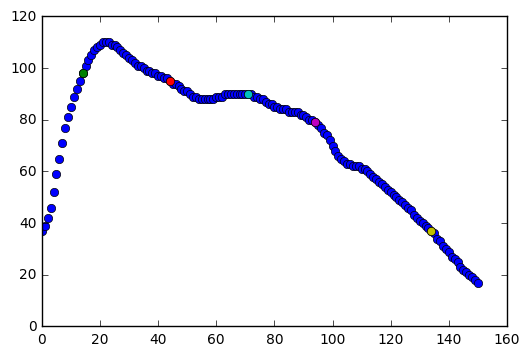

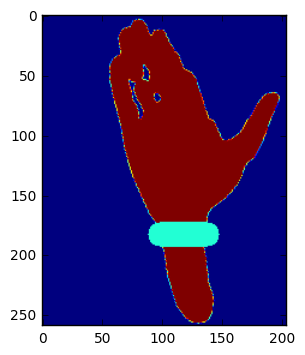

In [237]:
frame = cv2.imread('/home/taras/Downloads/thand2.png', -1)

thresholded = processImage(frame)
wrist, bbox, hand, direction = getWrist(thresholded)

draw_line(frame, wrist)
draw_contours(frame, bbox)
plt.show()

#plt.imshow(frame)
#plt.show()

plt.imshow(hand)
plt.show()


In [238]:
cap = cv2.VideoCapture(0)

#Kernel matrices for morphological transformation
#kernel_square = np.ones((5,5),np.uint8)
#kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))    

wrist = []

try:
    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()
    
        if ret == False:
            continue
        
        thresholded = processImage(frame)
        wrist, bbox, hand, direction = getWrist(thresholded)
        
        if len(wrist) > 0:        
            draw_line(frame, wrist)
            draw_contours(frame, bbox)
            draw_line(frame, direction)
            
        cv2.imshow('Hand detec',frame)
        cv2.imshow('mask',thresholded)
        
        if (hand.shape[0] > 0 and hand.shape[1] > 0):
            cv2.imshow('hnd',hand)
       
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
except KeyboardInterrupt:
    cap.release()
    cv2.destroyAllWindows()
    print ("Released")
except Exception as e :
    cap.release()
    cv2.destroyAllWindows()
    print (e)    

Released


[32, 158]


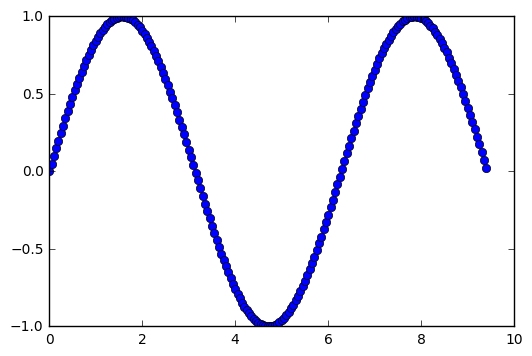

In [15]:
from scipy import signal
xs = np.arange(0, np.pi * 3, 0.05)
data = np.sin(xs)
peakind = signal.find_peaks_cwt(data, np.arange(1,10))
peakind, xs[peakind], data[peakind]
print peakind
plt.plot(xs, data, 'o')
plt.show()

In [11]:
#helpers

#from scipy.signal import argrelextrema
#maxm = argrelextrema(np.array(blurred), np.less_equal, order=15)

#plot peaks
#for k in maxm:   
    #plt.plot((k[0]), (k[1]), 'o')

#plt.plot(range(len(dists)), blurred, 'o') #dists[:, 1:4], 'o')
#for k in maxm:   
    #plt.plot((k), (blurred[k]), 'o')        
#plt.plot((a[0], a[0]), (a[1], a[2]), '-')

#x1, y1 = a[1], a[0]
#x2, y2 = a[2], a[0]
#draw_line(rotated, [int(x1) + dt, int(x2) + dt, int(y1) + dy, int(y2)+ dy])
#draw_contours(rotated, rt_bbox)
#plt.imshow(rotated)
#plt.show()

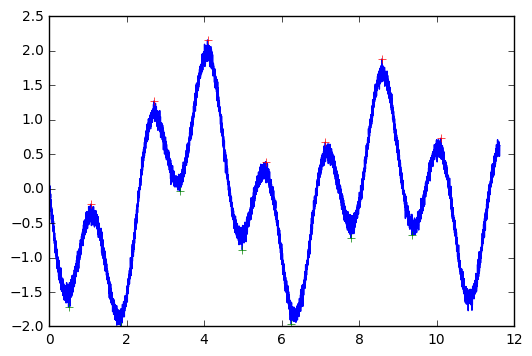